In [1]:
from IPython.display import HTML

In [2]:
HTML("""
<style>
    #notebook-container {
    width: 80% !important;
}
.dataTable {
    width: 100% !important;
}
.dataTables_scrollBody {
    width: 100% !important;
}
.dataTables_scrollHead {
    width: 100% !important;
}
.dataTables_filter {
   float: right !important;
}
.output_html {
    max-width: calc(100%) !important;
}
.rendered{
    font-size: 125%;
}
</style>
""")

In [3]:
html1 = '<img src="https://cdn.ifsc-climbing.org/images/News/Placeholders/IFSC_News_-_IFSC_placeholder.jpg" width="900" align="center"/>'
HTML(html1)

# IFSC World Cup Bouldering Analysis

The International Federation of Sport Climbing ([IFSC](https://www.ifsc-climbing.org/)) was founded in 2007 with the goal of encouraging, promoting, and developing the sport of climbing worldwide. With its addition to the most recent [Summer Olympics](https://olympics.com/en/sports/sport-climbing/), climbing in general has seen a huge spike in interest. Speed climbing in particular has taken the title of "Fastest Sport" in the Olympic games, with the fastest time of just barely over 5 seconds! But this project isn't going to focus on speed - rather, it's going  to focus on the wonderful discipline of [bouldering](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiy0vaGl87-AhVmJEQIHVoTCTQQFnoECE4QAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FBouldering&usg=AOvVaw2NEyaJhSIoQOZarHveFkWy).

Bouldering is rock climbing in its purest form. No ropes, no harnesses - just you and the wall. With bouldering being one of the more accessible disciplines in climbing (the others being [lead](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiu76PzlM7-AhWgJ0QIHaerAMsQFnoECBkQAw&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FLead_climbing&usg=AOvVaw35RDg9EAD7fL1lNoQQOkPk) and [speed](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi80Yr8lM7-AhWUKEQIHbijAP0QFnoECBUQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FSpeed_climbing&usg=AOvVaw2tZ7FhGxzCcb18zN0so1dU)), it's no surprise that it's rapidly growing in popularity worldwide. All you need is a pair of climbing shoes, some chalk, and a willingness to push yourself to your absolute limits. 

## Project Goals

In this analysis, I aim to help shed some light on boulderers from around the world. I have scraped the results from the IFSC website for all of the World Cup Events from 2007 to present day in the hopes of answering the following questions:
* Who are the most successful climbers?
    * Who has the most gold medals?
    * Which climbers have made it to the finals the most?
* Which country produces the best climbers?
    * Are any countries more dominant than others?
* How have climbers performed over time?
    * Do any climbers stand out from the rest?
    
I aim to update this every time a new event takes place, so that the results and the analysis are as up-to-date as possible.

## Combining the Data

In [4]:
# IMPORT LIBRARIES & TOOLS
import pandas as pd
import numpy as np
import itables
import glob
import os
import re

import seaborn as sns
import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "notebook"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
itables.init_notebook_mode(all_interactive=False)
cf.go_offline()

# Remove unnecessary control items in figures (for Plotly)
config = {
    'modeBarButtonsToRemove': ['zoomIn', 'zoomOut', 'resetScale2d', 'select2d', 'lasso2d'],
    'responsive': True,
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'png',  # one of png, svg, jpeg, webp
        'filename': 'ifsc-analysis',
        'scale': 1
      }
}

#SET UP DIRECTORY STRUCTURE
DATA_DIR = os.path.join(
    os.path.dirname(os.path.realpath("__file__")), "data"
)

BOULDER_MEN_DIR   = os.path.join(DATA_DIR, "Boulder/Men")
BOULDER_WOMEN_DIR = os.path.join(DATA_DIR, "Boulder/Women")

# HELPER FUNCTIONS
def clean_boulder(df):
    """
    Returns a dataframe where each score has been broken out
    into multiple columns for easier manipulation.
    
    df: dataframe containing results for all bouldering events
    """
    # Gets tops and zones for qualifications
    df[['Q_Top', 'Q_Zone']] = df['Qualification'].str.split('T', expand=True)
    df['Q_Zone'] = df['Q_Zone'].str.split('Z', expand=True)[0]
    df[['Qualification', 'Q_Top_Att', 'Q_Zone_Att']] = df['Qualification'].str.split(expand=True)

    # Gets tops and zones for semi-finals
    df[['S_Top', 'S_Zone']] = df['Semi-Final'].str.split('T', expand=True)
    df['S_Zone'] = df['S_Zone'].str.split('Z', expand=True)[0]
    df[['Semi-Final', 'S_Top_Att', 'S_Zone_Att']] = df['Semi-Final'].str.split(expand=True)

    # Gets tops and zones for finals
    df[['F_Top', 'F_Zone']] = df['Final'].str.split('T', expand=True)
    df['F_Zone'] = df['F_Zone'].str.split('Z', expand=True)[0]
    df[['Final', 'F_Top_Att', 'F_Zone_Att']] = df['Final'].str.split(expand=True)

    new_cols = ['Q_Top', 'Q_Zone', 'Q_Top_Att', 'Q_Zone_Att',
                'S_Top', 'S_Zone', 'S_Top_Att', 'S_Zone_Att',
                'F_Top', 'F_Zone', 'F_Top_Att', 'F_Zone_Att']

    # Convert all new columns to int
    for col in new_cols:
        df[col] = df[col].astype('float', errors = 'ignore')

    return df

# Function to correct the old scoring syntax
def convert_score(score):
    """
    Returns a new string representing the converted score.
    Old syntax: xTw yBz
    New syntax: xTyZ w x
    x,y,w,z: number of attempts
    T, B/Z: tops & zones, respectively
    
    score: string representation of climber's results
    """
    if score:
        tmp = str(score)
        if 'b' in tmp.lower():
            tops, top_att = tmp.lower().split()[0].split('t')
            zones, zone_att = tmp.lower().split()[1].split('b')

            new_score = tops + 'T' + zones + 'Z ' + top_att + ' ' + zone_att
            return new_score
        return score
    return score

# Function to display a single climber's results
def check_climber(df, name):
    """
    Returns a dataframe showing results for each event for given
    climber.
    
    df: dataframe containing results for all bouldering events
    name: name of climber you want to examine
    """
    name = name.upper()
    individual = df.groupby(df['Name']).get_group(name).reset_index(drop=True)
    return individual

# Function to show the count of a climber's round appearances
def count_round_appearances(df, name):
    """
    Prints a count of the number of times a climber has made it
    to a specific round.
    
    df: df containing results from all scraped events
    name: name of climber you want to examine
    """
    name = name.upper()
    # Gets number of time climber appeared for each round
    q = df.groupby(df['Name']).get_group(name).count()['Qualification']
    s = df.groupby(df['Name']).get_group(name).count()['Semi-Final']
    f = df.groupby(df['Name']).get_group(name).count()['Final']
    
    print(f'{name} appearances:')
    print(f'{"Qualification round:" :>20} {q :>3}')
    print(f'{"Semi-Final round:" :>20} {s :>3}')
    print(f'{"Final round:" :>20} {f :>3}')
    
def get_bouldering_results(directory):
    """
    Combines all .csv files in given directory into a single dataframe.
    
    directory: directory containing all the .csv files
    """
    # Grabs all .csv files in given directory and combine into dataframe
    all_files = glob.glob(os.path.join(directory, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    
    # Clean up some column/datatype issues
    df['Year'] = df['Event'].apply(lambda x: re.search("(\d{4})", x).group(1)) # Gets year of event
    df['Year'] = df['Year'].astype(int)
    df['Event'] = df['Event'].str.replace('IFSC - C', 'IFSC C').str.replace('Worldcup', 'World Cup')
    df['Rank'] = df['Rank'].fillna(-1).astype('int') # Fixes DNS rank    
    df['Qualification'] = df['Qualification'].apply(convert_score) # Fixes old scoring syntax
    df['Semi-Final'] = df['Semi-Final'].apply(convert_score)
    df['Final'] = df['Final'].apply(convert_score)
    return df

def show_table(df, col, center=0, srt="desc"):
    if center:
        return itables.show(df, maxBytes=1e6, scrollY="400px", scrollCollapse=True, paging=False, style="margin:auto")
    else:
        return itables.show(df,
                            classes="hover order-column dt-head-right dt-body-right",
                            maxBytes=1e6,
                            scrollY="400px",
                            scrollCollapse=True,
                            lengthMenu=[20, 50, 100],
                            order=[[col, srt]])

# IMPORT SCRAPED DATA
boulder_men_all_results = get_bouldering_results(BOULDER_MEN_DIR)

# Constant to be used in other functions
YEARS = np.unique(boulder_men_all_results['Year'])
show_table(boulder_men_all_results, 8)

<IPython.core.display.Javascript object>

As we can see from the above, there are over 7880 rows of data across *all* of the World Cup events we scraped earlier. We can use the search bar to look at the results of just a single climber to get an idea of their overall performance. For example, one of my favorite climbers is the two-time Bouldering World Cup Gold Medalist Jongwon Chon from South Korea. If we type his name into the search bar above you can see all of his results from his participation in the IFSC. You can see a quick summary of his appearances below.

In [5]:
count_round_appearances(boulder_men_all_results, 'jongwon chon')

JONGWON CHON appearances:
Qualification round:  48
   Semi-Final round:  43
        Final round:  27


As seen above, Jongwon Chon has appeared in 48 qualification rounds (as of May 1, 2023), and has made it to an astounding 27 finals! That's incredibly impressive considering how difficult it is to consistently perform at such a high level!

# Climber Statistics

Now we can look at the entirety of the results for men's bouldering (the exact same process can be followed for women's bouldering). The following function first checks to see if we have a .csv file that contains all of the data already. If we do, it loads it. If not, then it creates a new one - though it does take some time because it does require a complete scrape of the IFSC site to try and get each climber's height.

In [6]:
def get_bouldering_stats(df, category='men'):
    """
    Returns a dataframe showing the top 3 climbers (if applicable)
    grouped by country.
    
    df: dataframe containing aggregated results for each unique climber
    category: men's or women's category
    """
    # Sets correct filename
    if category.lower() == 'men':
        csv = 'boulder_stats_men.csv'
    else:
        csv = 'boulder_stats_women.csv'
    
    file = DATA_DIR + '\\' + csv
    
    # Create a new dataframe with athlete's ID, name, and country
    clean_df = df.drop_duplicates(subset=['Name', 'ID'])[['ID', 'Name', 'Country']]

    # Counts number of appearances per round per climber
    qual_all = df.groupby(['ID', 'Name'])['Qualification'].count()
    semi_app = df.groupby(['ID', 'Name'])['Semi-Final'].count()
    final_app = df.groupby(['ID', 'Name'])['Final'].count()

    # Merges the above dataframes
    rounds = pd.merge(pd.merge(qual_all, semi_app , left_on=['ID', 'Name'], right_index=True), final_app, left_on=['ID', 'Name'], right_index=True)
    clean_df = pd.merge(clean_df, rounds, left_on=['ID', 'Name'], right_index=True)

    # Calculates percentages of appearances in each round
    clean_df['Q_Pct'] = round((clean_df['Qualification'] / clean_df['Qualification']) * 100, 2)
    clean_df['S_Pct'] = round((clean_df['Semi-Final'] / clean_df['Qualification']) * 100, 2)
    clean_df['F_Pct'] = round((clean_df['Final'] / clean_df['Qualification']) * 100, 2)
    clean_df = clean_df.sort_values('Final', ascending=False).reset_index(drop=True)

    # Saves/overwrites data so we don't have to scrape later    
    clean_df.to_csv(file)
    # print(f'Saved data as {csv}!')
    
    return clean_df

# def get_height(df, cat, stats_df):
    # Convert 'ID' to string so we can scrape site for heights (~33 minutes)
    # print(f'Gathering {cat}\'s height - please be patient...')
    # df['ID'] = df['ID'].apply(str)
    # scraper = IFSCScraper()
    # df['Height'] = df['ID'].apply(lambda x: scraper.get_athlete_height(x))
    # scraper.end_session()

    # Number of climbers that have a height listed on the IFSC site
    # have_height = (~stats_df['Height'].str.contains('-')).sum()
    # no_height = (stats_df['Height'].str.contains('-')).sum()
    # print(f'Only {have_height} climbers ({(have_height/no_height)*100:.2f}%) have their height listed!')
    # return df

boulder_men_stats = get_bouldering_stats(boulder_men_all_results, 'men')
show_table(boulder_men_stats, 5)

Saved data as boulder_stats_men.csv!


As you can see from the above, from our original ~7880 rows, we have condensed it down to just over 1300 unique male climbers. Along with their respective countries of origin, you can see the number of times each climber appeared in the qualification, semi-final, and final rounds. Additionally, you can see a percentage of times the climber reached that specific round. We're not done yet however, as there is still some important information we can figure out.

## Podium Count
How many times did each climber reach the podium? How many Bronze, Silver, or Gold medals did they get? Now that we have all of the data in a single dataframe, we can find out! To do this, we can use the [.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method, as well as a clever use of the [.size](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.size.html?highlight=size#pandas.core.groupby.DataFrameGroupBy.size) and [.unstack](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html?highlight=unstack#pandas.DataFrame.unstack) methods.

In [7]:
def calculate_podiums(all_df, stats_df, country = False):
    """
    Returns a dataframe showing each unique climber's aggregated
    results across all scraped events, including # of times they
    earned a podium position.
    
    all_df: dataframe containing all non-aggregated results
    stats_df: dataframe containing aggregated results for all unique climbers
    """
    # Get a dataframe of all climbers who had a rank of 1, 2, or 3 in any event
    podiums = all_df[(all_df['Rank'] <= 3) & (all_df['Rank'] > 0)]

    # Get another new dataframe with the count of occurences each climber got each rank
    if country:
        medals = podiums.groupby(['Rank', 'Country']).size().unstack(0)
    else:
        medals = podiums.groupby(['ID', 'Name', 'Rank']).size().unstack()
    medals = medals.rename(columns={-1: 'Podium', 1: 'Gold', 2: 'Silver', 3: 'Bronze'})
    medals['Podium'] = medals['Gold'] + medals['Silver'] + medals['Bronze']

    # Merge with our stats dataframe and add new % columns
    if country:
        stats_df           = stats_df.merge(medals, how='left', left_on=['Country'], right_on=['Country']).fillna(0)
    else:
        stats_df           = stats_df.merge(medals, how='left', left_on=['ID', 'Name'], right_on=['ID', 'Name']).fillna(0)
    stats_df['P_Pct']      = round((stats_df['Podium'] / stats_df['Qualification']) * 100, 2)
    stats_df['Gold_Pct']   = round((stats_df['Gold'] / stats_df['Qualification']) * 100, 2)
    stats_df['Silver_Pct'] = round((stats_df['Silver'] / stats_df['Qualification']) * 100, 2)
    stats_df['Bronze_Pct'] = round((stats_df['Bronze'] / stats_df['Qualification']) * 100, 2)
    
    # Convert these columns to 'int'
    int_col = ['Podium', 'Bronze', 'Silver', 'Gold']
    stats_df[int_col] = stats_df[int_col].astype(int)

    # Reordering the columns into a more logical format
    if country:
        cols = ['Country', 'Qualification', 'Semi-Final', 'Final', 'Podium',
                'Bronze', 'Silver', 'Gold', 'Q_Pct', 'S_Pct', 'F_Pct', 'P_Pct',
                'Bronze_Pct', 'Silver_Pct', 'Gold_Pct']
    else: # take note of 'Height' - temporarily removed it
        cols = ['ID', 'Name', 'Country', 'Qualification', 'Semi-Final',
                'Final', 'Podium', 'Bronze', 'Silver', 'Gold', 'Q_Pct', 'S_Pct',
                'F_Pct', 'P_Pct', 'Bronze_Pct', 'Silver_Pct', 'Gold_Pct']

    stats_df = stats_df[cols]
    return stats_df

boulder_men_stats = calculate_podiums(boulder_men_all_results, boulder_men_stats)
show_table(boulder_men_stats, 9)

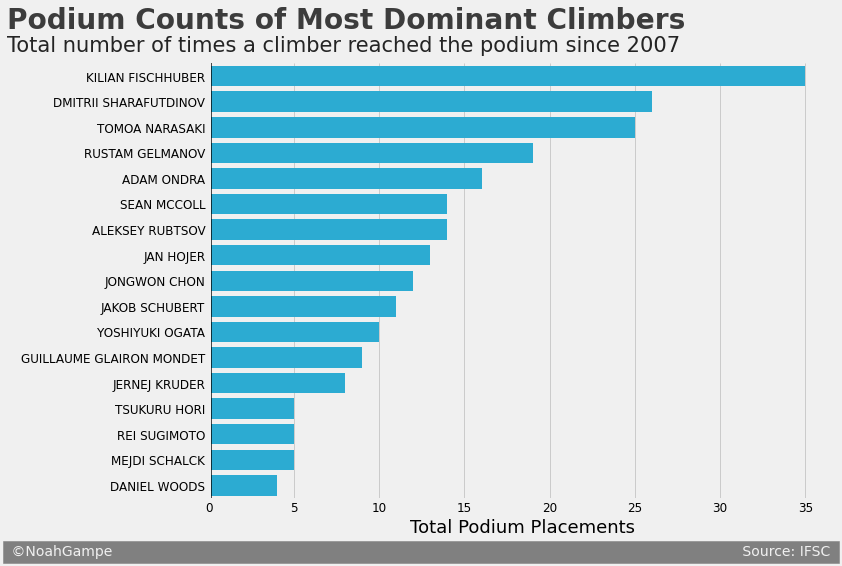

In [8]:
def plot_bar(df, col, col2, title, sub, xoffset, yoffset, sig):
    """
    Displays a static bar graph showing the total counts of podium appearances
    of the top performing climbers between 2007-2022
    
    df: dataframe containing relevant data
    col: data to be displayed along x-axis
    col2: data to be displayed along y-axis
    title, sub, xoffset, yoffset, sig: variables for styling the various parts of the vis
    """
    #figure details
    fig = plt.figure(figsize=(10,8), facecolor='#f0f0f0')
            
    #plot
    ax = sns.barplot(data=df, x=col, y=col2, color='#10baee')
        
    #styling
    #blue = #10baee
    #pink = #ff007e
    
    ax.set_facecolor('#f0f0f0')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axvline(x=0, color="black", linewidth=6, alpha=.7)
    ax.set_xlabel('Total Podium Placements', fontsize=18)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    #title & subtitle
    ax.text(xoffset,0.94, s=title, fontsize=28, weight="bold", alpha=.75, transform=fig.transFigure)
    ax.text(xoffset,0.9, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=xoffset, y=yoffset,
            s=" ©NoahGampe" + ' '*sig + "Source: IFSC ",
            fontsize=14, color="#f0f0f0", backgroundcolor="grey", transform=fig.transFigure)
    
    plt.show()
    
title = "Podium Counts of Most Dominant Climbers"
sub = "Total number of times a climber reached the podium since 2007"
plot_bar(boulder_men_stats[boulder_men_stats['Podium'] > 0].sort_values('Podium',ascending=False), 'Podium', 'Name', title, sub, -0.2, 0.025, 140)

Now we have a more robust dataframe with more relevant information. Additionally, we can use this dataframe with our previous function to check out a single climber and see all their stats. A reminder that these stats only represent the IFSC World Cup events.

In [9]:
individual2 = check_climber(boulder_men_stats, 'jongwon chon')
individual2

,ID,Name,Country,Qualification,Semi-Final,Final,Podium,Bronze,Silver,Gold,Q_Pct,S_Pct,F_Pct,P_Pct,Bronze_Pct,Silver_Pct,Gold_Pct
0,2052,JONGWON CHON,KOR,48,43,27,12,4,3,5,100.0,89.58,56.25,25.0,8.33,6.25,10.42


## Country Statistics

In [10]:
def get_bouldering_country_stats(df):
    """
    Returns a dataframe showing results of all scraped IFSC events
    grouped by country.
    
    df: dataframe containing results for all bouldering events
    """
    clean_df = pd.DataFrame()
    clean_df['Country'] = df['Country'].unique()

    # Counts number of appearances per round per country
    qual_all = df.groupby(['Country'])['Qualification'].count()
    semi_app = df.groupby(['Country'])['Semi-Final'].count()
    final_app = df.groupby(['Country'])['Final'].count()

    # Merges the above with our previous dataframe
    clean_df = pd.merge(pd.merge(qual_all, semi_app , left_on='Country', right_index=True),
                  final_app, left_on='Country', right_index=True)

    # Calculates percentages of appearances vs total events
    clean_df = clean_df.sort_values('Final', ascending=False).reset_index()
    clean_df['Q_Pct'] = round((clean_df['Qualification'] / clean_df['Qualification'].sum()) * 100, 2)
    clean_df['S_Pct'] = round((clean_df['Semi-Final'] / clean_df['Semi-Final'].sum()) * 100, 2)
    clean_df['F_Pct'] = round((clean_df['Final'] / clean_df['Final'].sum()) * 100, 2)
    return clean_df

boulder_men_country_stats = get_bouldering_country_stats(boulder_men_all_results)
show_table(boulder_men_country_stats, 3)

Above we can see a table that details how many times a climber from a given country participated in a specific round. Right away we can see that Japan has had the most number of climbers participate in Qualification rounds *and* Finals. Similar to before, we can add some more detail to this chart to get the number of times a country achieved a podium position.

In [11]:
country_stats = calculate_podiums(boulder_men_all_results, boulder_men_country_stats, True)
show_table(country_stats, 7)

Looking at the above table, we can quickly see that Russia, Austria, and Japan have the most number of gold medals *by far*. In fact, they have the most Bronze and Silver medals too! Clearly, these three countries are doing something right with their climbers training regimens. To put it into perspective visually, the below chart shows just how far ahead the three countries are in terms of podium placements.

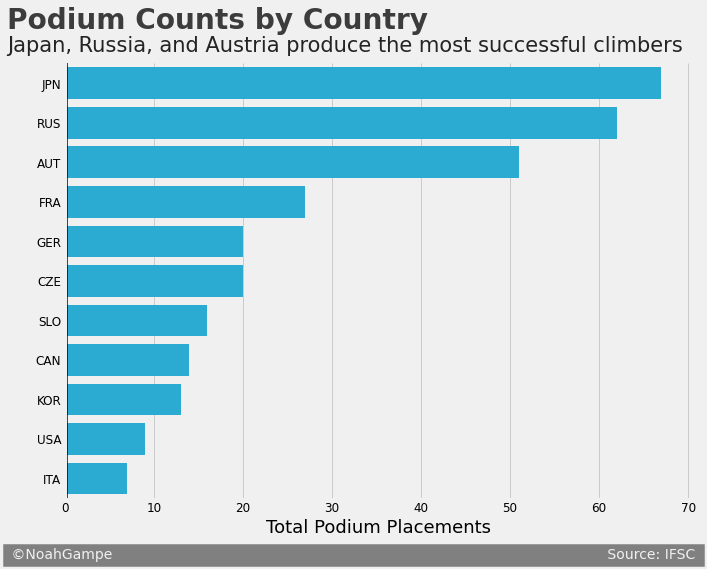

In [12]:
title = "Podium Counts by Country"
sub = "Japan, Russia, and Austria produce the most successful climbers"
plot_bar(country_stats[country_stats['Podium'] > 0].sort_values('Podium',ascending=False), 'Podium', 'Country', title, sub, 0, 0.02, 110)

## Country Performance Over Time

Which countries had the strongest performance over time? We can create a new dataframe, one that shows the number of times a climber from a given country reached the final round of a world cup event per year. According to [section 8.6 of the IFSC Rules](https://cdn.ifsc-climbing.org/images/Website/2023_IFSC_Rules_112.pdf), the quota for the Final round shall be six (6) climbers. To properly view all climbers who made it to the final round, we shall be looking at all climbers who have a rank less than or equal to 6.

In [13]:
def get_country_yearly_stats(df):
    """
    Returns df containing number of times a country has been represented in the finals.
    
    df: dataframe containing results for all bouldering events
    """
    stats_df = df[(df['Rank'] <= 6) & (df['Rank'] > 0)] # Removes any -1 or 'DNS' competitors    
    stats_df = stats_df.groupby(['Year'])['Country'].value_counts().unstack().fillna(0).astype('int')
    stats_df.index = stats_df.index.astype('int')
    return stats_df
    
country_perf = get_country_yearly_stats(boulder_men_all_results)
show_table(country_perf, 0, "asc")

The above dataframe contains the number of finalists per country, per year. We will make a visualization of this in a second. We can sum up the totals over all the years to see which country produces the most IFSC World Cup finalists.

In [14]:
total_finalists = country_perf.sum().sort_values(ascending=False)

# TO-DO FIGURE OUT HOW TO DISPLAY THIS ONE
total_finalists = total_finalists.reset_index(name="# of Finalists")
itables.show(total_finalists, style="table-layout:auto;width:auto;margin:auto;", scrollY="300px", scrollCollapse=True, paging=False)

## Number of Finalists Per Country Over Time

In [15]:
def plot_line(df, title, sub, xoffset, yoffset, sig, subset=[]):
    """
    Displays a static line graph showing the total number of finalists
    per country over time.
    
    df: dataframe containing relevant data
    subset: list of countries you want to examine
    title, sub, xoffset, yoffset, sig: variables for styling the various parts of the vis
    """
    #figure details
    fig = plt.figure(figsize=(14,12), facecolor='#f0f0f0')
       
    #plot details
    if subset:
        palette = ['#4167a6', '#9d65b4', '#ea5c97','#ff715d' ,'#ffa600']
        ax = sns.lineplot(data=df[subset], linewidth=3.0, dashes=False, palette=palette[:len(subset)]) #displays only subset
        ax = sns.lineplot(data=df.drop(subset, axis=1), linewidth=3.0, alpha=0.2)
    else:
        ax = sns.lineplot(data=df, linewidth=3.0) #displays each country equally
    
    # ax = sns.lineplot(data=df.drop(['JPN', 'RUS', 'AUT'], axis=1), linewidth=3.0, alpha=0.2)
    ax.axhline(y=0, color="black", linewidth=4, alpha=.7)
    ax.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    #title & subtitle
    ax.text(xoffset, 0.93, s=title, fontsize=28, weight="bold", alpha=.75, transform=fig.transFigure)
    ax.text(xoffset, 0.9, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=xoffset, y=yoffset,
            s=" ©NoahGampe" + ' '*sig + "Source: IFSC ",
            fontsize=14, color="#f0f0f0", backgroundcolor="grey", transform=fig.transFigure)
    
    plt.show()
    
title = "Number of Finalists Per Country Over Time"
sub = "Japan begins to dominate after 2015, while Russia and France begin to fall behind"
# plot_line(country_perf, title, sub, 0.05, 0.055 ,160)
# plot_line(country_perf, title, sub, 0.05, 0.055 ,180, ['JPN', 'RUS', 'FRA'])

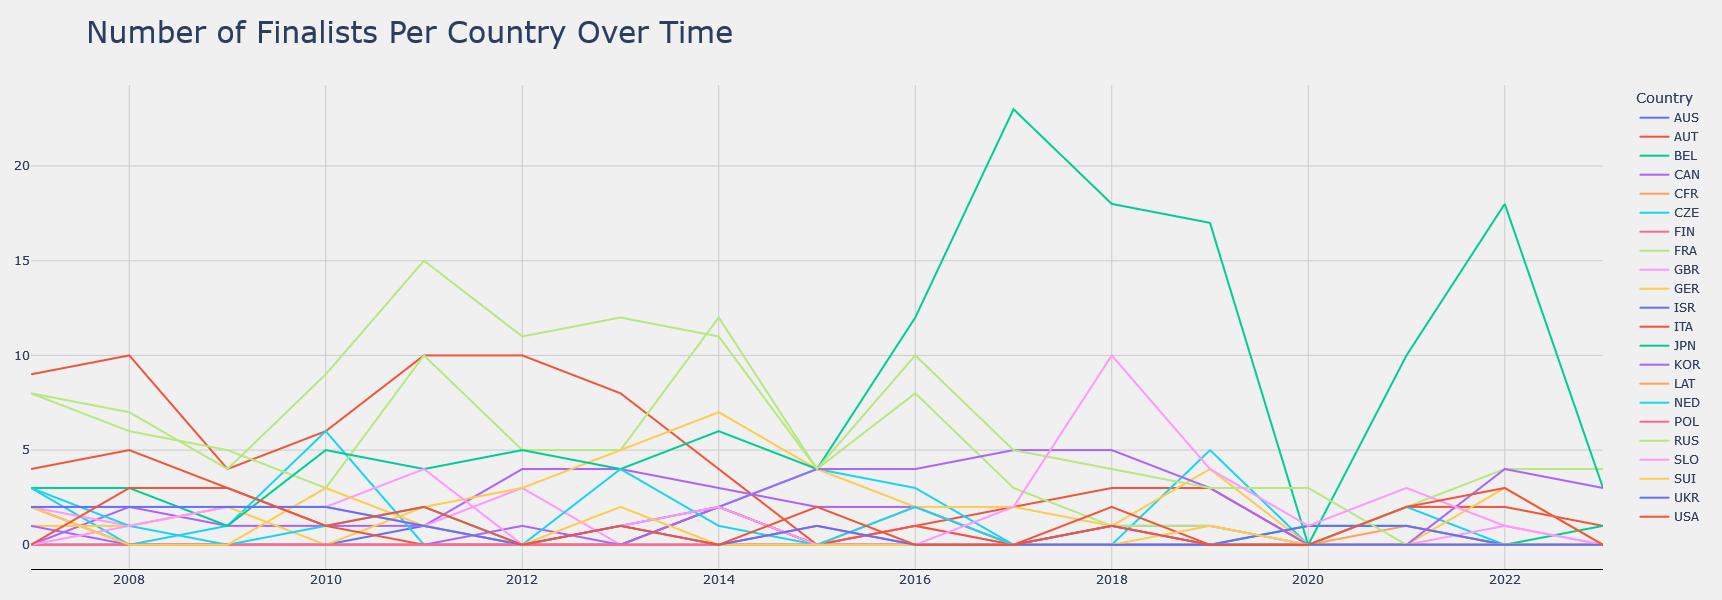

In [16]:
fig = px.line(country_perf,
              width=1000,
              height=600
             )
fig.update_layout(
    title=dict(text=title, font=dict(size=30)),
    plot_bgcolor='#f0f0f0',
    paper_bgcolor='#f0f0f0',
    yaxis_title=None,
    xaxis_title=None,
    margin=dict(l=25, r=25, t=85, b=25)
)
fig.update_xaxes(
    showline=True,
    linecolor='black',
    gridcolor='#cbcbcb'
)
fig.update_yaxes(
    showticklabels=True,
    gridcolor='#cbcbcb'
)

If we examine the above results, it's very clear that Japan and Russia dominate bouldering competitions (in terms of the number of times one of their climbers reached the finals). Fascinatingly, Japan has reached the finals round at least once per year for every single year except 2020 - which was right in the middle of the COVID-19 pandemic, when the [IFSC cancelled two competition events](https://www.ifsc-climbing.org/index.php/news/388-ifsc-world-cups-in-salt-lake-city-and-seoul-cancelled) due to health and safety concerns. This resulted in 2020 only have a *single* bouldering event for the entire season. That one event was the European Continental Championships, so non-Europeans weren't allowed to compete anyways!


## Plotly Graph Function
Below we create a basic plotly graph that allows us to pass in a dataframe and a column, and it will generate an interactive plotly chart that let's us filter the data and see the visualization.

In [17]:
def gen_plotly(df, col, title):
    """
    Displays an interactive plotly graph using the given column and dataframe.
    
    df: dataframe containing relevant data
    col: data to be displayed along x-axis
    title: title (and subtitle) for given visualization
    """
    vals = list(df[col].unique().astype(str))
    
    # Creates graph object figure
    fig = go.Figure()

    # Creates dictionary of dataframes
    top5_dict = {}
    if df[col].dtype == 'object': #strings
        for val in vals:
            top5_dict[val] = df[df[col] == val]
    else: #ints
        for val in vals:
            top5_dict[val] = df[df[col] == int(val)]

    # Adds trace for each year to our graph object
    for val in vals:
        fig.add_trace(
            go.Bar(
                x=top5_dict[val]['Name'],
                y=top5_dict[val]['Podiums'],
                name=val,
                marker=dict(color='#10baee'),
                visible=True if val == vals[-1] else False
            )
        )

    # Creates list of buttons for each year
    buttons_opts = []
    for i, val in enumerate(vals):
        args = [False] * len(vals)
        args[i] = True

        buttons_opts.append(
            dict(
                method='update',
                label=val,
                args=[{
                    'visible': args, #this is the key line!
                    'title': val,
                    'showlegend': False
                }]
            )
        )

    # Styling
    fig.update_layout(
        updatemenus = [go.layout.Updatemenu(
            active=len(vals)-1,
            buttons=buttons_opts,
            x=1.12,
            xanchor='right',
            y=1.1,
            yanchor='top'
            )],
        yaxis={ 
            'tickvals': [*range(0, 30)]
        },
        title=dict(text=title, font=dict(size=30)),
        width=800,
        height=500,
        plot_bgcolor='#f0f0f0',
        paper_bgcolor='#f0f0f0',
        yaxis_title=None,
        xaxis_title=None,
        margin=dict(l=25, r=25, t=85, b=25)
    )

    fig.update_xaxes(
        showline=True,
        linecolor='black'
    )

    fig.update_yaxes(
        showticklabels=True,
        gridcolor='#cbcbcb'
    )
    
    fig.show(config=config)

## Top Climbers By Year

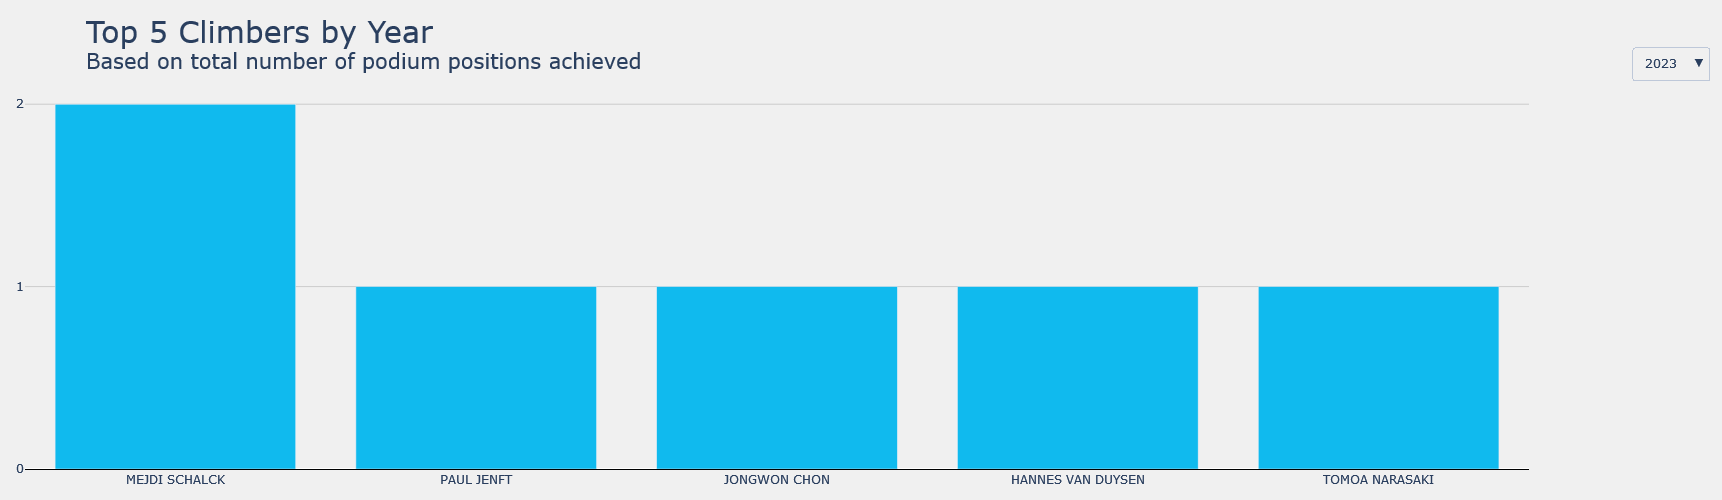

In [18]:
def get_top_by_year(df):
    """
    Returns a dataframe showing the top 5 climbers grouped by competition
    year, based on the number of times they reached the podium.
    
    df: dataframe containing results for all bouldering events
    """
    df = df[(df['Rank'] <= 3) & (df['Rank'] > 0)] # Only get climbers on podium
    df = df.groupby(['Year'])[['Name']].value_counts().to_frame(name='Podiums').reset_index() # Each climber's podium count by year    
    df = df.groupby(['Year'], sort=False).head(5).reset_index(drop=True).astype({'Year': 'int'}) # Top 5 climbers per year by podium count
    return df
    
top_by_year = get_top_by_year(boulder_men_all_results)
title = "Top 5 Climbers by Year<br><sup>Based on total number of podium positions achieved"
gen_plotly(top_by_year, 'Year', title)

## Top Climbers By Country

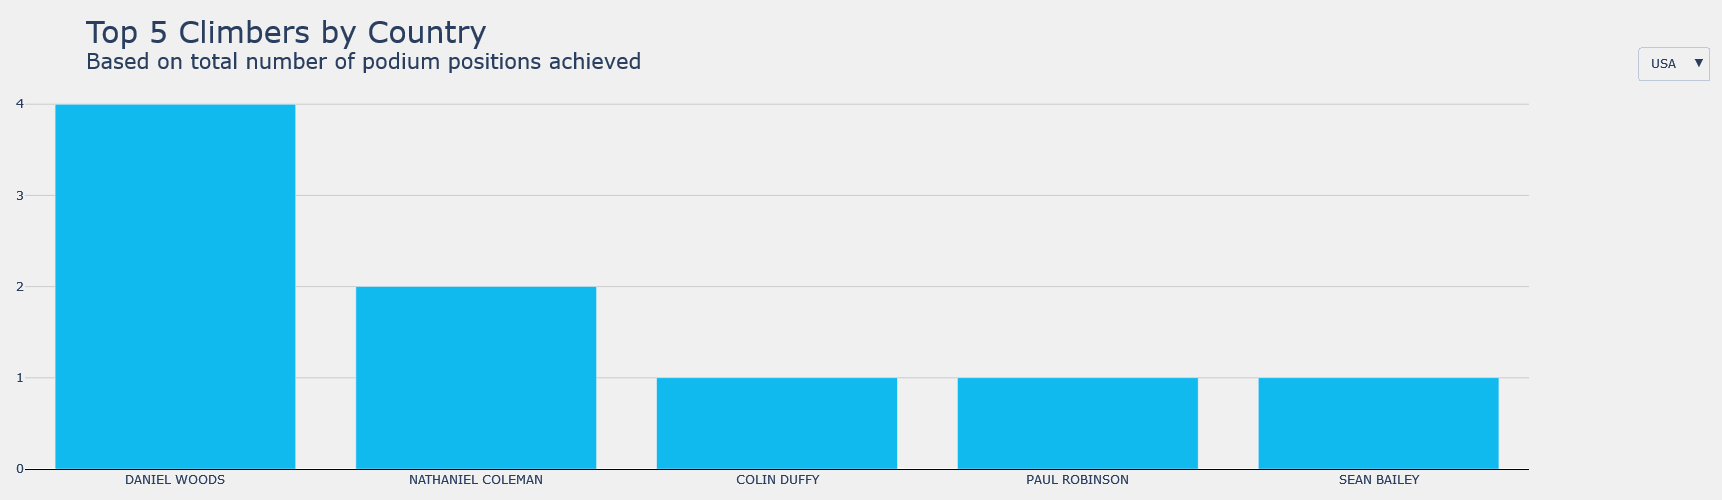

In [19]:
def get_top_by_country(df):
    """
    Returns a dataframe showing the top 5 climbers (if applicable)
    grouped by country.
    
    df: dataframe containing results for all bouldering events
    """
    df = df[(df['Rank'] <= 3) & (df['Rank'] > 0)] # Only get climbers on podium
    df = df.groupby(['Country'])[['Name']].value_counts().to_frame(name='Podiums').reset_index() # Each climber's podium count by year    
    df = df.groupby(['Country'], sort=False).head().reset_index(drop=True) # Top 5 climbers per year by country
    return df
    
top_by_country = get_top_by_country(boulder_men_all_results)
title = "Top 5 Climbers by Country<br><sup>Based on total number of podium positions achieved"
gen_plotly(top_by_country, 'Country', title)

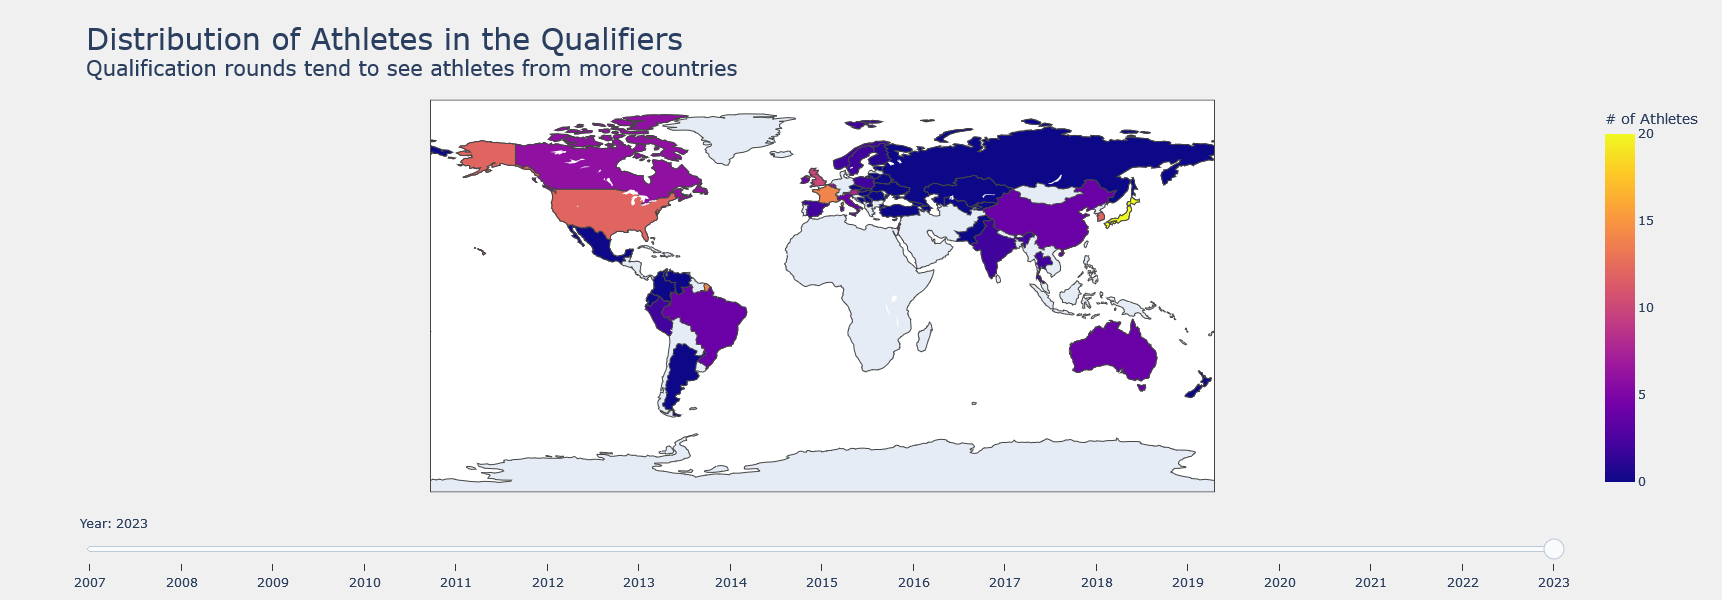

In [20]:
def get_round_stats(df, rnd=0):
    """
    Returns an aggregated dataframe with the climbers for a given round.
    
    rnd: the round you want data for (0: qualification, 1: semi-final, 2: final, 3:podium)
    """
    if rnd == 1:
        df = df[(df['Rank'] <= 20) & (df['Rank'] > 0)] # Semi-Final
    elif rnd == 2:
        df = df[(df['Rank'] <= 6) & (df['Rank'] > 0)]  # Final
    elif rnd == 3:
        df = df[(df['Rank'] <= 3) & (df['Rank'] > 0)]  # Podium
    
    df = df.groupby(['Year'])['Country'].value_counts().unstack().fillna(0).astype('int')
    return df
    
qual   = get_round_stats(boulder_men_all_results)
semif  = get_round_stats(boulder_men_all_results, 1)
final  = get_round_stats(boulder_men_all_results, 2)
podium = get_round_stats(boulder_men_all_results, 3)

def gen_choro(df, title, sub):
    """
    Displays an interactive plotly choropleth map with year-slider to display the 
    distribution of athletes by country over time.
    
    df: dataframe containing relevant data
    title, sub: title & subtitle for the visualization
    """    
    data_bal = []
    for i in YEARS:
        data_upd = [dict(type='choropleth',
                         name=str(i),
                         locations=df.loc[i].index,
                         z=df.loc[i],
                         locationmode='ISO-3',
                         colorbar=dict(title='# of Athletes'),
                         visible=True if i == YEARS[-1] else False
                        )
                   ]    
        data_bal.extend(data_upd)
    
    # Slider creation
    steps = []
    # for j in range(0, len(data_bal)):
    for idx, j in enumerate(YEARS):
        step = dict(method="restyle",
                    args=["visible", [False] * len(data_bal)],
                    label=str(j))
        step['args'][1][idx] = True
        steps.append(step)

    # Sliders layout:
    sliders = [dict(active=len(YEARS) - 1,
                    currentvalue={"prefix": "Year: "},
                    pad={"t": 20},
                    steps=steps)]

    # Plot layout
    title = f"{title}<br><sup>{sub}"
    layout = dict(title=dict(text=title,
                             font=dict(size=30)),
                  geo=dict(scope='world',
                           projection=dict()),
                  sliders=sliders,
                  width=1000,
                  height=600,
                  plot_bgcolor='#f0f0f0',
                  paper_bgcolor='#f0f0f0')

    fig = go.Figure(data=data_bal, layout=layout)
    fig.update_layout(autotypenumbers='strict')
    fig.show(config=config)
    
title = "Distribution of Athletes in the Qualifiers"
sub1 = "Qualification rounds tend to see athletes from more countries"
gen_choro(qual, title, sub1)

In [21]:
# title = "Distribution of Athletes in the Semi-Finals"
# sub2 = "South America tends to struggle to get through to the semi-finals"
# gen_choro(semif, title, sub2)

In [22]:
# title = "Distribution of Athletes in the Finals"
# sub3 = "Japan, Russia, and France get through to the finals very consistently"
# gen_choro(final, title, sub3)

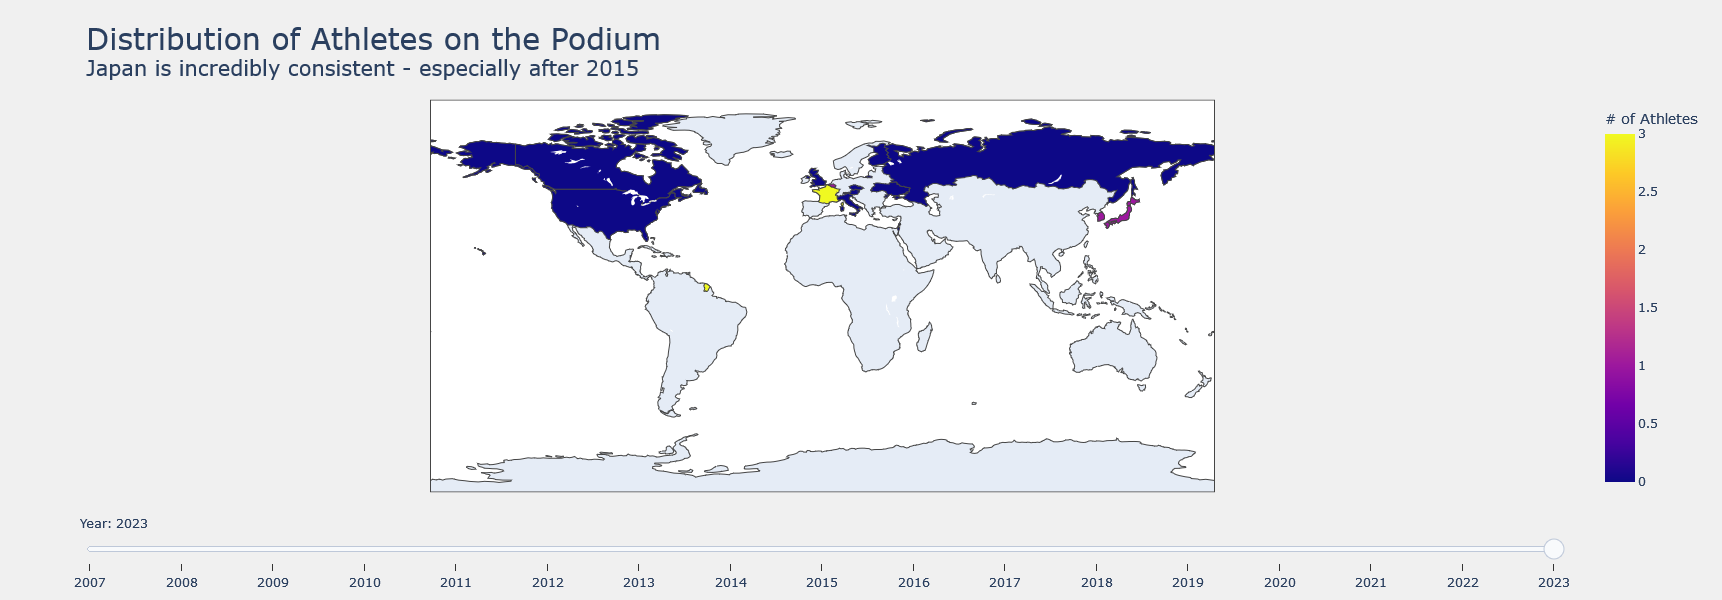

In [23]:
title = "Distribution of Athletes on the Podium "
sub4 = "Japan is incredibly consistent - especially after 2015"
gen_choro(podium, title, sub4)

## Individual Finals Appearances Over Time

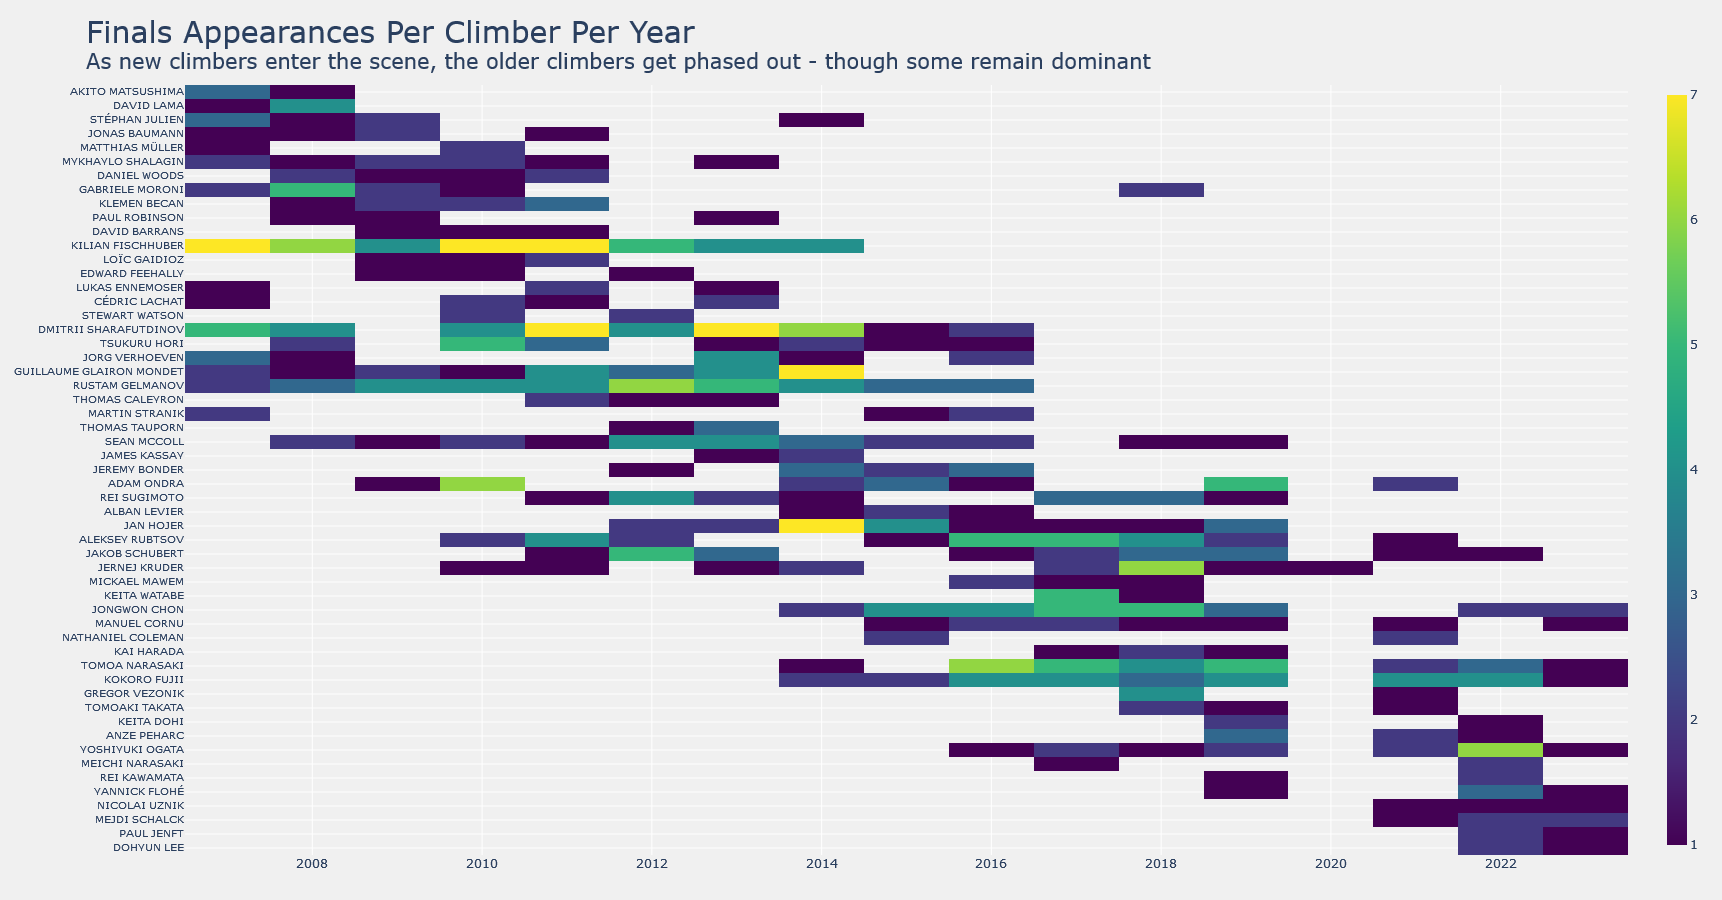

In [24]:
def plot_heatmap(df):
    finalists = df[df['Final'].notna()]
    num_finals = finalists.groupby('Name', as_index=False)['Final'].count()
    climbers = np.unique(num_finals.loc[num_finals['Final'] >= 3, 'Name'])
    years = np.unique(finalists['Year'])
    
    # count number of finals per climber and year, and sorts
    dat = pd.DataFrame(np.nan, columns=years, index=climbers)
    grp = finalists[finalists["Name"].isin(climbers)].groupby(["Name", "Year"], as_index=False).count()
    for idx, row in grp.iterrows():
        dat.loc[row["Name"], row["Year"]] = row["Final"]
    srt = ((dat * dat.columns).mean(1)/dat.mean(1)).argsort() #weighted average

    heat = go.Heatmap(x=years,
                      y=dat.iloc[srt].index, 
                      z=dat.iloc[srt],
                      name='',
                      hoverongaps=False,
                      hovertemplate="<b>%{y}</b><br>Year: %{x}<br>Finals: %{z}",
                      coloraxis="coloraxis"
                     )    

    title = ("Finals Appearances Per Climber Per Year<br>"
            "<sup>As new climbers enter the scene, the older climbers get phased out - though some remain dominant")

    fig = go.Figure(heat)
    fig.update_layout(width=1200, height=900,
                      title=dict(text=title,
                                 font=dict(size=30)),
                      coloraxis=dict(colorscale='Viridis',
                                     colorbar_thickness=20),
                      plot_bgcolor='#f0f0f0',
                      paper_bgcolor='#f0f0f0',
                      yaxis_autorange='reversed',
                      yaxis=dict(autorange='reversed',
                                 tickfont=dict(size=9)),
                      margin=dict(l=25, r=25, t=85, b=45))

    fig.show(config=config)
    
plot_heatmap(boulder_men_all_results)

### Observations

There are clearly some climbers who have performed well for an extended period of time:
* Kilian Fischhuber
* Dmitrii Sharafutdinov
* Rustam Gelmanov
* Sean McColl
* Adam Ondra
* Aleksey Rubtsov
* Jakob Schubert
* Jan Hojer
* Jongwon Chon
* Tomoa Narasaki
* Kokoro Fujii
* Yoshiyuki Ogata

All of the above climbers have either appeared in finals for over 10+ years, or have appeared in a large number of finals. Currently, it does seem like climbers from Japan are performing better for longer periods of time.